<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson05_VAE_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 5. Simple VAE excerise
1. Re-use lesson 3's code
2. Try to implement your simple VAE using the MNIST dataset
3. Explore some simple ideas about the generative model
4. Compare the results with Pytorch


In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transform

In [10]:
tt = transform.Compose([transform.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
test_data = MNIST(root='./data', train=False, transform=tt)

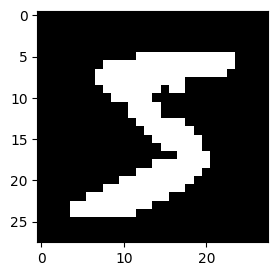

In [11]:
def transform_from_torch_to_numpy(torch_data):
    features_np = torch_data.data.numpy()
    labels_np = torch_data.targets.numpy()

    features_np = np.resize(features_np, (features_np.shape[0], features_np.shape[1] * features_np.shape[2]))

    # Simplify the exercise
    features_np[features_np != 0] = 1

    labels = np.zeros((labels_np.shape[0], 10))
    for i in range(10):
        labels[labels_np==i, i] = 1.

    return features_np, labels

train_features, train_labels = transform_from_torch_to_numpy(train_data)
test_features, test_labels = transform_from_torch_to_numpy(test_data)

import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
x = np.resize(train_features[0], (28, 28))
plt.imshow(x, cmap='gray')
plt.show()

In [12]:
def shuffle_dataset(n, batch_size):
    idices= np.array(range(n))
    np.random.shuffle(idices)
    batch_sample_size = int((n - n % batch_size) / batch_size)
    m = int(batch_size * batch_sample_size)
    a = idices[0:m].reshape((batch_size, batch_sample_size))
    b = idices[m:].reshape((1, n % batch_size))
    return a

def get_precision(predict, y):
    a = np.argmax(predict, axis=1)
    b = np.argmax(y, axis=1)
    print(np.sum(a == b) / y.shape[0])

In [13]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        m = dL_by_dZ.shape[0]
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        #dZ/dW = X.T (n+1, m) .dot dL/dZ = (m, out)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) / m #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        #self.Y_hat = self.process_function(Z)
        self.Y_hat = Z
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        #Y_hat = softmax(Z)
        Y_hat = Z
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [14]:
class VAE:
    def __init__(self, size_of_features, size_of_bottle):
        self.model = Operator_Packager([
            Linear(size_of_features, 100),
            Sigmoid_Active_Function(),
            Linear(100, 50),
            Sigmoid_Active_Function(),
            Linear(50, size_of_bottle),
            Linear(size_of_bottle, 50),
            Sigmoid_Active_Function(),
            Linear(50, 100),
            Sigmoid_Active_Function(),
            Linear(100, size_of_features),
            Sigmoid_Active_Function()
        ])
        self.bottle_layer = 3

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        Y = self.model.predict(X)
        return Y

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

    def encode(self, X):
        Z = X
        for i in range(self.bottle_layer):
            Z = self.model.operator_list[i].predict(Z)
        return Z

    def decode(self, Z):
        X = Z
        for i in range(self.bottle_layer, len(self.model.operator_list)):
            X = self.model.operator_list[i].predict(X)
        return X

Epoch 1
-------------------------------
t: 1  loss : 356634.04505963594


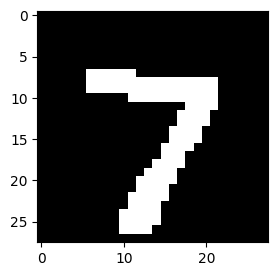

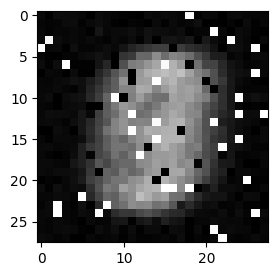

t: 2  loss : 330385.54504349676
t: 3  loss : 323337.5363351898
t: 4  loss : 316705.0462176715
t: 5  loss : 310333.2544989526
t: 6  loss : 305976.7212566538
t: 7  loss : 300838.19362144807
t: 8  loss : 297652.6009441332
t: 9  loss : 293685.0997846306
t: 10  loss : 325876.7379799139
Epoch 11
-------------------------------
t: 11  loss : 283011.0878112896
t: 12  loss : 314590.9531311581
t: 13  loss : 285589.676347321
t: 14  loss : 307654.5905111062
t: 15  loss : 288074.41381137964
t: 16  loss : 295578.1083239347
t: 17  loss : 282580.24879069277
t: 18  loss : 263260.76803677634
t: 19  loss : 267094.215297328
t: 20  loss : 278636.2676236211
Epoch 21
-------------------------------
t: 21  loss : 255808.0256340803


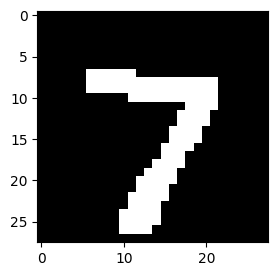

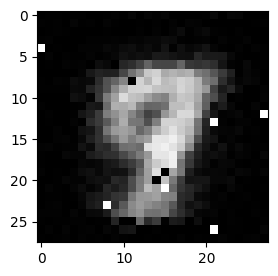

t: 22  loss : 268529.1855167211
t: 23  loss : 257320.7919476546
t: 24  loss : 258803.40480318293
t: 25  loss : 268671.55191669357
t: 26  loss : 243691.241351357
t: 27  loss : 256993.22588942363
t: 28  loss : 261848.9169933993
t: 29  loss : 246109.3444155974
t: 30  loss : 249117.7995672937
Epoch 31
-------------------------------
t: 31  loss : 255081.25602404017
t: 32  loss : 233883.3876884719
t: 33  loss : 241152.1099676649
t: 34  loss : 253973.76880767132
t: 35  loss : 251138.80276831263
t: 36  loss : 234298.5860105249
t: 37  loss : 231034.31209574486
t: 38  loss : 235721.88516176763
t: 39  loss : 231500.7945868499
t: 40  loss : 226585.55760893648
Epoch 41
-------------------------------
t: 41  loss : 235738.59862662392


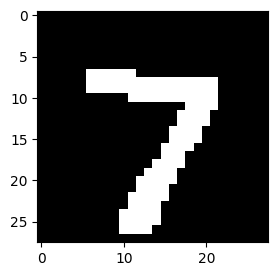

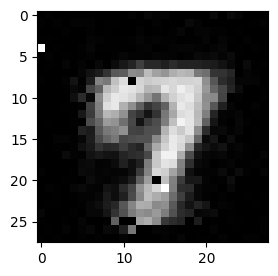

t: 42  loss : 241895.474441188
t: 43  loss : 227450.4523403623
t: 44  loss : 222194.02366191984
t: 45  loss : 226613.36780035376
t: 46  loss : 218062.37901504122
t: 47  loss : 215074.23613140997
t: 48  loss : 219681.26805889033
t: 49  loss : 226953.7600696817
t: 50  loss : 221229.03967834264
Epoch 51
-------------------------------
t: 51  loss : 210654.31919818593
t: 52  loss : 222078.08040562287
t: 53  loss : 221788.03733445273
t: 54  loss : 215922.2058151087
t: 55  loss : 221400.68336073967
t: 56  loss : 224104.19063832622
t: 57  loss : 219486.28314279774
t: 58  loss : 215393.8843183038
t: 59  loss : 203878.9501439961
t: 60  loss : 207430.36502281623
Epoch 61
-------------------------------
t: 61  loss : 216226.68916555945


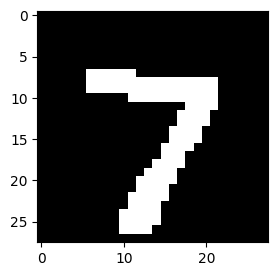

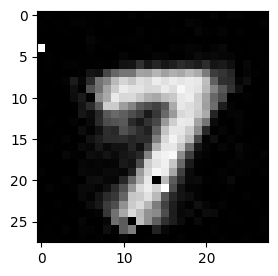

t: 62  loss : 221405.7236557552
t: 63  loss : 216574.17373965445
t: 64  loss : 207474.17294877712
t: 65  loss : 217269.95425514676
t: 66  loss : 211721.2679140576
t: 67  loss : 206148.4107145254
t: 68  loss : 205300.82277963855
t: 69  loss : 215385.52626607707
t: 70  loss : 215154.55323886685
Epoch 71
-------------------------------
t: 71  loss : 211693.9755007335
t: 72  loss : 202911.34469306466
t: 73  loss : 209711.7916053099
t: 74  loss : 223610.77946012968
t: 75  loss : 209628.8925440448
t: 76  loss : 197193.78087385788
t: 77  loss : 205454.6093136698
t: 78  loss : 206897.35597575005
t: 79  loss : 210116.2022040119
t: 80  loss : 203258.72111352207
Epoch 81
-------------------------------
t: 81  loss : 199891.55351272068


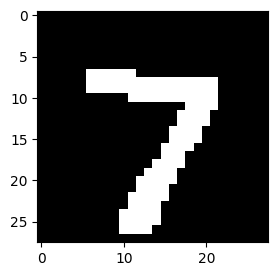

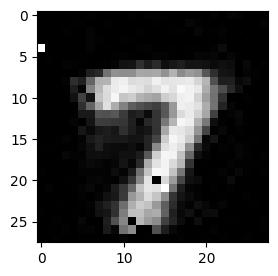

t: 82  loss : 199702.58573550035
t: 83  loss : 209463.9735039564
t: 84  loss : 199055.5759698188
t: 85  loss : 200432.7867575381
t: 86  loss : 204668.77539314557
t: 87  loss : 212279.4666752117
t: 88  loss : 202404.42995832863
t: 89  loss : 200654.23503469164
t: 90  loss : 198365.3891830008
Epoch 91
-------------------------------
t: 91  loss : 202970.8123379229
t: 92  loss : 206538.0282407629
t: 93  loss : 206480.76147009234
t: 94  loss : 203274.0626152666
t: 95  loss : 193882.2531976629
t: 96  loss : 196447.01822662685
t: 97  loss : 202691.344839535
t: 98  loss : 195704.80740056498
t: 99  loss : 185405.80316897508
t: 100  loss : 186469.0296316081
Epoch 101
-------------------------------
t: 101  loss : 192207.9383824381


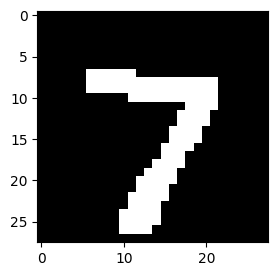

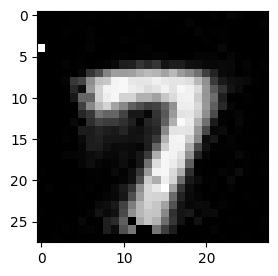

t: 102  loss : 195214.9958167072
t: 103  loss : 191677.15535111103
t: 104  loss : 191254.51210996148
t: 105  loss : 181879.18329120884
t: 106  loss : 188766.81331393667
t: 107  loss : 191542.312671361
t: 108  loss : 194337.4492168462
t: 109  loss : 188023.40576211692
t: 110  loss : 180999.4728871338
Epoch 111
-------------------------------
t: 111  loss : 184113.44300583677
t: 112  loss : 185125.42716143545
t: 113  loss : 194488.54182414574
t: 114  loss : 194345.92259124477
t: 115  loss : 189672.10840252758
t: 116  loss : 185187.15118850156
t: 117  loss : 185389.5645287972
t: 118  loss : 185905.1301196414
t: 119  loss : 187552.9647671067
t: 120  loss : 189914.46909064965
Epoch 121
-------------------------------
t: 121  loss : 196068.66740712323


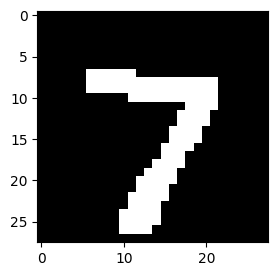

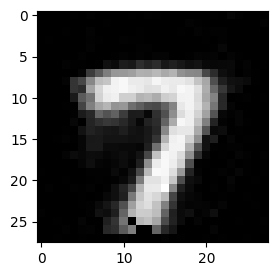

t: 122  loss : 187694.0982571112
t: 123  loss : 179651.5859776373
t: 124  loss : 182137.68742157018
t: 125  loss : 181570.7323066763
t: 126  loss : 192024.2980102231
t: 127  loss : 194052.9135282056
t: 128  loss : 186157.30271611494
t: 129  loss : 182899.66323273655
t: 130  loss : 179158.93123618583
Epoch 131
-------------------------------
t: 131  loss : 180515.02802454526
t: 132  loss : 187478.64490997352
t: 133  loss : 194058.97736458396
t: 134  loss : 185942.3245629546
t: 135  loss : 186106.41858855594
t: 136  loss : 181006.5851658284
t: 137  loss : 181040.93825598533
t: 138  loss : 186303.46954206514
t: 139  loss : 188132.1967784933
t: 140  loss : 194489.99028640214
Epoch 141
-------------------------------
t: 141  loss : 185944.7912441487


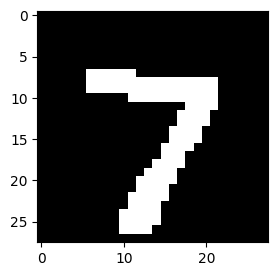

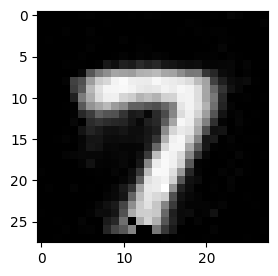

t: 142  loss : 184302.50103375106
t: 143  loss : 178842.818661294
t: 144  loss : 173763.40283442845
t: 145  loss : 184310.6631148262
t: 146  loss : 186102.38655806144
t: 147  loss : 187771.87958629118
t: 148  loss : 188079.53934629282
t: 149  loss : 186403.6399831635
t: 150  loss : 183539.87945874833
Epoch 151
-------------------------------
t: 151  loss : 184370.44544337102
t: 152  loss : 183190.02682301388
t: 153  loss : 192296.8827531027
t: 154  loss : 188978.47345478172
t: 155  loss : 182035.7230593262
t: 156  loss : 177610.67588630732
t: 157  loss : 181560.78971624863
t: 158  loss : 178991.58690993494
t: 159  loss : 182339.24098013443
t: 160  loss : 182305.75097452928
Epoch 161
-------------------------------
t: 161  loss : 192321.54981951197


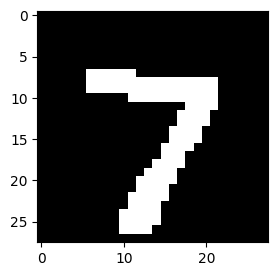

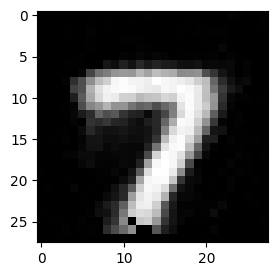

t: 162  loss : 187244.75798378472
t: 163  loss : 176191.5227691104
t: 164  loss : 180138.63802031992
t: 165  loss : 173830.7603533475
t: 166  loss : 185574.78508067888
t: 167  loss : 187040.96977077096
t: 168  loss : 186196.78388041572
t: 169  loss : 187334.34024845963
t: 170  loss : 175410.06780154872
Epoch 171
-------------------------------
t: 171  loss : 180343.90533395848
t: 172  loss : 182370.75998715108
t: 173  loss : 179781.46504665978
t: 174  loss : 176951.32717707384
t: 175  loss : 173663.50710627175
t: 176  loss : 181135.1116572763
t: 177  loss : 186252.91531900325
t: 178  loss : 184045.99683856504
t: 179  loss : 175846.83588687718
t: 180  loss : 176325.21552310218
Epoch 181
-------------------------------
t: 181  loss : 180277.05508691003


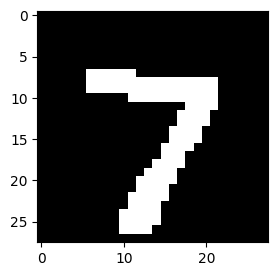

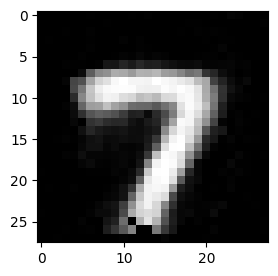

t: 182  loss : 184992.09530403255
t: 183  loss : 182355.6823148234
t: 184  loss : 176191.5541386468
t: 185  loss : 175147.82091125846
t: 186  loss : 179513.06497213658
t: 187  loss : 180078.10056057456
t: 188  loss : 184964.36931933335
t: 189  loss : 183290.00887949538
t: 190  loss : 173496.6065392799
Epoch 191
-------------------------------
t: 191  loss : 172815.21305543996
t: 192  loss : 176814.72114536006
t: 193  loss : 171185.69701219417
t: 194  loss : 180929.81445832603
t: 195  loss : 180898.3440203045
t: 196  loss : 184239.7824691199
t: 197  loss : 180056.01731399147
t: 198  loss : 176643.3642399176
t: 199  loss : 173387.5815411265
t: 200  loss : 174984.41729893873
Epoch 201
-------------------------------
t: 201  loss : 174620.18505346426


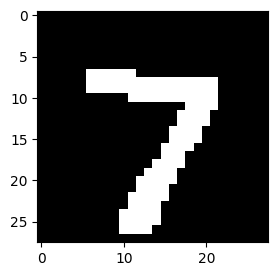

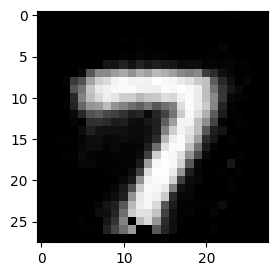

t: 202  loss : 182611.99504229907
t: 203  loss : 189499.42221125192
t: 204  loss : 189009.6821000143
t: 205  loss : 179011.52524105358
t: 206  loss : 175278.03026022427
t: 207  loss : 173736.08647186327
t: 208  loss : 180116.28878364322
t: 209  loss : 173741.46570185837
t: 210  loss : 172050.16405767185
Epoch 211
-------------------------------
t: 211  loss : 168570.52537649017
t: 212  loss : 174075.90546970346
t: 213  loss : 169446.88879857777
t: 214  loss : 172033.64826926004
t: 215  loss : 171154.23284350333
t: 216  loss : 181538.25371860285
t: 217  loss : 171100.9436706349
t: 218  loss : 179957.49908181353
t: 219  loss : 168848.05125213653
t: 220  loss : 166870.84445910086
Epoch 221
-------------------------------
t: 221  loss : 174720.2833439607


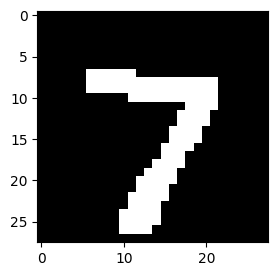

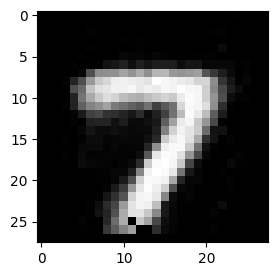

t: 222  loss : 175988.87673586284
t: 223  loss : 182092.33936453264
t: 224  loss : 185736.31094770302
t: 225  loss : 177311.46408182965
t: 226  loss : 168879.83221976785
t: 227  loss : 170721.54414790252
t: 228  loss : 169130.49932063158
t: 229  loss : 175406.451411107
t: 230  loss : 177223.956756453
Epoch 231
-------------------------------
t: 231  loss : 176375.27541631428
t: 232  loss : 182131.87442383933
t: 233  loss : 186242.22417791744
t: 234  loss : 172344.314236734
t: 235  loss : 175625.35709608177
t: 236  loss : 179365.63109915773
t: 237  loss : 182564.63363277202
t: 238  loss : 178659.68088735722
t: 239  loss : 169877.1972224652
t: 240  loss : 167818.80873051911
Epoch 241
-------------------------------
t: 241  loss : 183725.60323846975


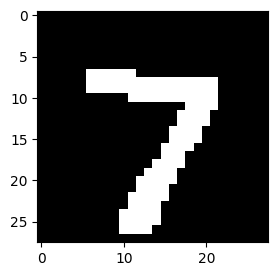

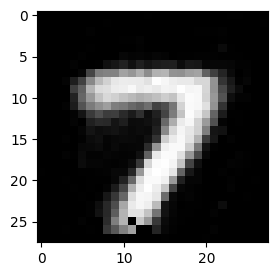

t: 242  loss : 175199.7650179526
t: 243  loss : 179990.6846544161
t: 244  loss : 181481.42101106388
t: 245  loss : 173224.80385311693
t: 246  loss : 176130.93676204066
t: 247  loss : 178706.284474079
t: 248  loss : 190040.2690429794
t: 249  loss : 175863.21355233708
t: 250  loss : 172313.6769893173
Epoch 251
-------------------------------
t: 251  loss : 167214.49577086302
t: 252  loss : 172691.97451144858
t: 253  loss : 174652.76833486455
t: 254  loss : 175224.1108210938
t: 255  loss : 176734.64558822123
t: 256  loss : 181525.03165646663
t: 257  loss : 170904.6769166622
t: 258  loss : 166638.94769755282
t: 259  loss : 178559.21775161359
t: 260  loss : 179347.36248719934
Epoch 261
-------------------------------
t: 261  loss : 184558.58705249534


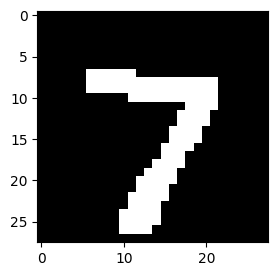

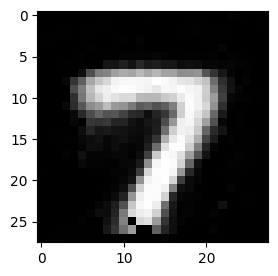

t: 262  loss : 176298.39272239784
t: 263  loss : 172667.95747015753
t: 264  loss : 169691.26704172566
t: 265  loss : 168464.85369985856
t: 266  loss : 169449.44266089523
t: 267  loss : 185644.80490563466
t: 268  loss : 175129.94896716272
t: 269  loss : 182712.9760590442
t: 270  loss : 176855.7161850948
Epoch 271
-------------------------------
t: 271  loss : 169611.07605625864
t: 272  loss : 165295.94863605022
t: 273  loss : 168642.21251486678
t: 274  loss : 167735.277717631
t: 275  loss : 177650.98855985055
t: 276  loss : 180026.63592722573
t: 277  loss : 178856.9586745309
t: 278  loss : 179041.24419670063
t: 279  loss : 173444.1969101292
t: 280  loss : 171549.82534838826
Epoch 281
-------------------------------
t: 281  loss : 171950.681837528


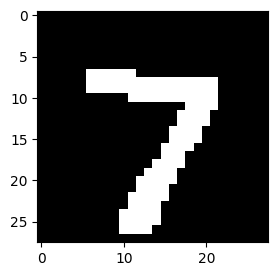

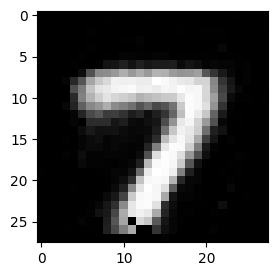

t: 282  loss : 175849.2511407611
t: 283  loss : 179147.29508555806
t: 284  loss : 171838.2004227914
t: 285  loss : 168107.76048204803
t: 286  loss : 164226.23895613145
t: 287  loss : 167229.2856386258
t: 288  loss : 172515.31566265775
t: 289  loss : 171525.894136783
t: 290  loss : 171065.43968346942
Epoch 291
-------------------------------
t: 291  loss : 177562.51260893853
t: 292  loss : 167349.63540176724
t: 293  loss : 168545.2445117453
t: 294  loss : 170553.13297307468
t: 295  loss : 168152.26865064673
t: 296  loss : 167379.06397706215
t: 297  loss : 168886.01889926314
t: 298  loss : 169685.7010091585
t: 299  loss : 178484.86569652325
t: 300  loss : 176343.54535397096


In [15]:
demo_vae = VAE(28*28, 2)
loss = Cross_Entropy_Loss()

epochs = 300
m = train_labels.shape[0]

for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_size = 30
    batch_matrix = shuffle_dataset(m, batch_size)

    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X = train_features[batch_index, :]
        Y = train_features[batch_index, :]

        Z = demo_vae.forward(X)
        #print(Z.shape)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_vae.backward(dL_by_dZ)

        demo_vae.update_weights(learning_rate = 0.35)

    print('t:', t+1, ' loss :', l)

    if (t % 20 == 0):
        X = test_features
        Y = demo_vae.predict(X)
        encode1 = np.resize(X[0], (28, 28))
        decode1 = np.resize(Y[0], (28, 28))

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(encode1, cmap='gray')
        plt.show()

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(decode1, cmap='gray')
        plt.show()

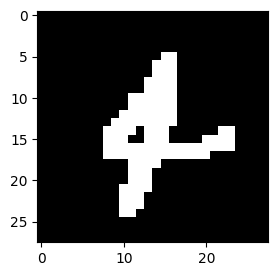

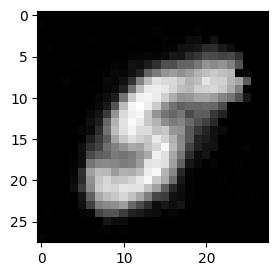

In [16]:
X = test_features
Y = demo_vae.predict(X)
encode1 = np.resize(X[300], (28, 28))
decode1 = np.resize(Y[300], (28, 28))

figure = plt.figure(figsize=(3, 3))
plt.imshow(encode1, cmap='gray')
plt.show()

figure = plt.figure(figsize=(3, 3))
plt.imshow(decode1, cmap='gray')
plt.show()

(array([2]),)


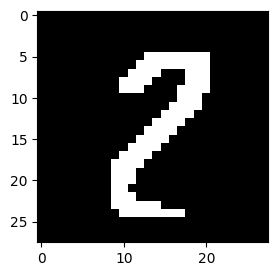

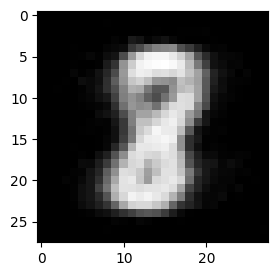

In [17]:
i = 613
label_i = test_labels[i]
print(np.where(label_i==1))
encode1 = np.resize(X[i], (28, 28))
decode1 = np.resize(Y[i], (28, 28))

figure = plt.figure(figsize=(3, 3))
plt.imshow(encode1, cmap='gray')
plt.show()

figure = plt.figure(figsize=(3, 3))
plt.imshow(decode1, cmap='gray')
plt.show()

(array([0]),)


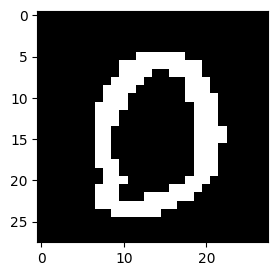

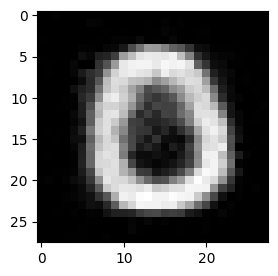

In [18]:
i = 1713
label_i = test_labels[i]
print(np.where(label_i==1))
encode1 = np.resize(X[i], (28, 28))
decode1 = np.resize(Y[i], (28, 28))

figure = plt.figure(figsize=(3, 3))
plt.imshow(encode1, cmap='gray')
plt.show()

figure = plt.figure(figsize=(3, 3))
plt.imshow(decode1, cmap='gray')
plt.show()

#Exercise 2. Add noise into the train data


Epoch 1
-------------------------------
t: 1  loss : 149566.34746538222


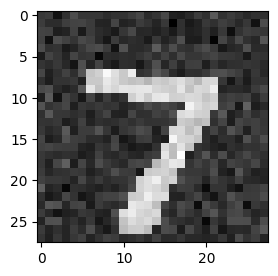

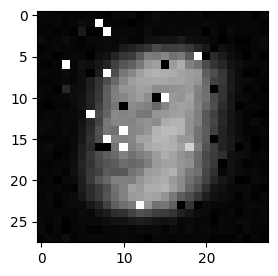

t: 2  loss : 146011.5090506899
t: 3  loss : 140355.7338284665
t: 4  loss : 137968.8198876811
t: 5  loss : 144602.94208289025
t: 6  loss : 134106.8656304529
t: 7  loss : 136797.16465825873
t: 8  loss : 131505.7032289655
t: 9  loss : 112897.61180889193
t: 10  loss : 118410.2447441641
Epoch 11
-------------------------------
t: 11  loss : 132764.52498446932
t: 12  loss : 129775.04642959255
t: 13  loss : 128569.65883501896
t: 14  loss : 114180.30622141108
t: 15  loss : 122424.64453088999
t: 16  loss : 129518.50262028971
t: 17  loss : 124128.5153333007
t: 18  loss : 112231.39261540731
t: 19  loss : 114620.05468436204
t: 20  loss : 120316.1800961883
Epoch 21
-------------------------------
t: 21  loss : 121546.19896290565


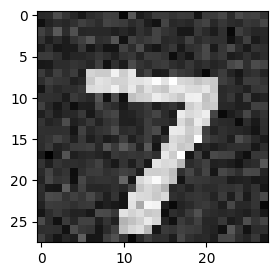

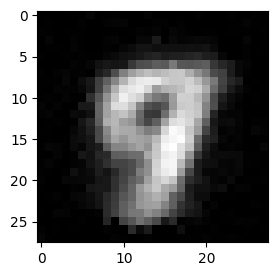

t: 22  loss : 104784.47158459768
t: 23  loss : 110630.71075216419
t: 24  loss : 106910.57590119567
t: 25  loss : 111001.66849094404
t: 26  loss : 102504.24642060218
t: 27  loss : 105676.45523313398
t: 28  loss : 107013.74177334442
t: 29  loss : 111309.92276852658
t: 30  loss : 107887.32683889322
Epoch 31
-------------------------------
t: 31  loss : 101268.189044755
t: 32  loss : 99705.86236879136
t: 33  loss : 105770.72285431396
t: 34  loss : 108718.14181176027
t: 35  loss : 105946.22978415023
t: 36  loss : 112429.74780484985
t: 37  loss : 109199.91309219175
t: 38  loss : 102208.06328639471
t: 39  loss : 101768.57382518287
t: 40  loss : 103712.14065819701
Epoch 41
-------------------------------
t: 41  loss : 103379.37505637678


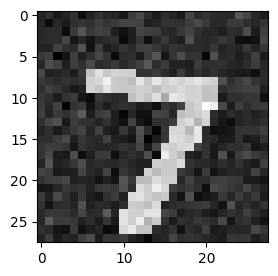

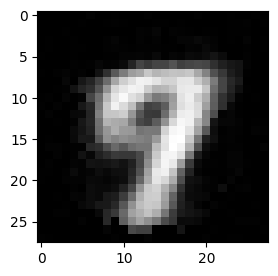

t: 42  loss : 103571.49652780977
t: 43  loss : 102932.22486670136
t: 44  loss : 100073.8789192369
t: 45  loss : 105476.43695536276
t: 46  loss : 97568.79578890973
t: 47  loss : 94587.48960772534
t: 48  loss : 96288.58649426825
t: 49  loss : 107155.82840820076
t: 50  loss : 94435.75617583338
Epoch 51
-------------------------------
t: 51  loss : 94732.20321327736
t: 52  loss : 102741.17094338062
t: 53  loss : 92507.93683453293
t: 54  loss : 93125.46376349732
t: 55  loss : 89048.73765341369
t: 56  loss : 96569.53006435906
t: 57  loss : 103876.80253764677
t: 58  loss : 97273.54736336086
t: 59  loss : 96119.64441209217
t: 60  loss : 93685.30691020338
Epoch 61
-------------------------------
t: 61  loss : 90834.13956622798


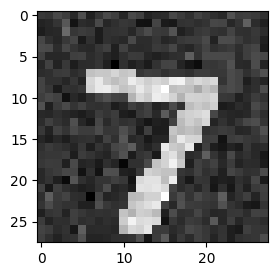

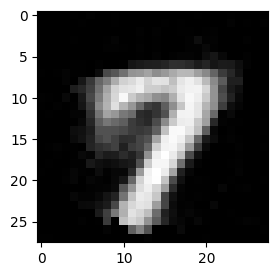

t: 62  loss : 94716.54412325507
t: 63  loss : 95055.81700017107
t: 64  loss : 93364.7786899384
t: 65  loss : 93566.79502436028
t: 66  loss : 90458.16495441529
t: 67  loss : 96754.99468584295
t: 68  loss : 92614.90593918176
t: 69  loss : 100186.02438066661
t: 70  loss : 90713.542289049
Epoch 71
-------------------------------
t: 71  loss : 92996.21461527886
t: 72  loss : 93027.84238347916
t: 73  loss : 99198.06537584477
t: 74  loss : 99853.3347601275
t: 75  loss : 90831.20869288075
t: 76  loss : 94342.32055802875
t: 77  loss : 89683.82787095068
t: 78  loss : 89562.81762754692
t: 79  loss : 91788.54865873164
t: 80  loss : 96682.96954806919
Epoch 81
-------------------------------
t: 81  loss : 92357.10776266821


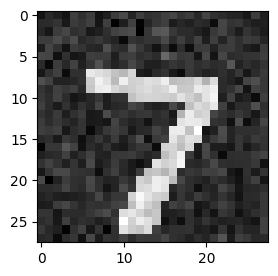

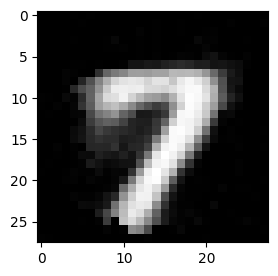

t: 82  loss : 87781.17662783572
t: 83  loss : 93303.91307335171
t: 84  loss : 90359.96823604277
t: 85  loss : 96915.46181374358
t: 86  loss : 91012.79262017114
t: 87  loss : 91409.75131060001
t: 88  loss : 102034.44273102739
t: 89  loss : 92905.93380143018
t: 90  loss : 88124.7098827389
Epoch 91
-------------------------------
t: 91  loss : 92272.53474785085
t: 92  loss : 87521.5295704851
t: 93  loss : 92687.95236562644
t: 94  loss : 89980.39457633256
t: 95  loss : 94642.74581726361
t: 96  loss : 89841.38271483952
t: 97  loss : 95150.28554771902
t: 98  loss : 93319.84313231199
t: 99  loss : 87564.8779661419
t: 100  loss : 89021.5132626138
Epoch 101
-------------------------------
t: 101  loss : 98920.10532342595


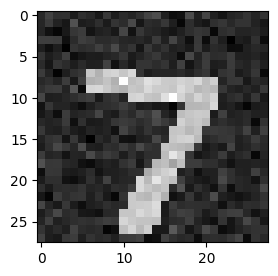

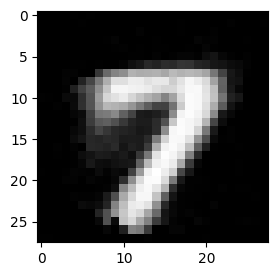

t: 102  loss : 85735.19399209107


KeyboardInterrupt: ignored

In [21]:
demo_vae = VAE(28*28, 2)
loss = Cross_Entropy_Loss()

epochs = 300
m = train_labels.shape[0]

for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_size = 60
    batch_matrix = shuffle_dataset(m, batch_size)

    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X_origin = train_features[batch_index, :]
        mu = 0.5
        std = 0.1
        noise = np.random.normal(mu, std, size = X_origin.shape)
        X = X_origin + noise
        Y = train_features[batch_index, :]

        Z = demo_vae.forward(X)
        #print(Z.shape)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_vae.backward(dL_by_dZ)

        demo_vae.update_weights(learning_rate = 0.35)

    print('t:', t+1, ' loss :', l)

    if (t % 20 == 0):
        X = test_features
        mu = 0.5
        std = 0.1
        noise = np.random.normal(mu, std, size = X.shape)
        X = X + noise
        Y = demo_vae.predict(X)
        encode1 = np.resize(X[0], (28, 28))
        decode1 = np.resize(Y[0], (28, 28))

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(encode1, cmap='gray')
        plt.show()

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(decode1, cmap='gray')
        plt.show()